In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.4MB/s 
     |████████████████████████████████| 460kB 43.4MB/s 
     |████████████████████████████████| 92kB 7.5MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import urllib.request
from konlpy.tag import Okt
from gensim.models import Word2Vec, KeyedVectors

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!pip install wikiextractor

     |████████████████████████████████| 51kB 6.8MB/s 


# 영화 리뷰

## 1. Load Data - 

In [ ]:
url = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt'

urllib.request.urlretrieve(url, filename = 'ratings.txt')

('ratings.txt', <http.client.HTTPMessage at 0x7f8112f30d50>)

In [ ]:
train_data = pd.read_table('ratings.txt')

train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


## 2. Data Preprocessing

In [ ]:
# 리뷰 개수 출력
print(len(train_data))

200000


In [ ]:
# NULL값 존재 유무
print(train_data.isnull().values.any())

True


### 1) NULL값 존재하는 행 제거

In [ ]:
train_data = train_data.dropna(how = 'any')

In [ ]:
print(train_data.isnull().values.any())

False


In [ ]:
print(len(train_data))

199992


### 2) 정규표현식을 통한 한글 외 문자 제거

In [ ]:
train_data['document'] = train_data['document'].str.replace('[^ㄱ-하-ㅣ가-힣]' , '')

In [ ]:
train_data.head()

,id,document,label
0,8112052,어릴때보고지금다시봐도재밌어요ㅋㅋ,1
1,8132799,디자인을배우는학생으로외국디자이너와그들이일군전통을통해발전해가는문화산업이부러웠는데사실우...,1
2,4655635,폴리스스토리시리즈는부터뉴까지버릴께하나도없음최고,1
3,9251303,와연기가진짜개쩔구나지루할거라고생각했는데몰입해서봤다그래이런게진짜영화지,1
4,10067386,안개자욱한밤하늘에떠있는초승달같은영화,1


### 3) 불용어 정의

In [ ]:
stopwords = ['의', '가', '이', '은', '들', '는',
             '좀', '잘', '걍', '과', '도',
             '를', '으로', '자', '에', '와', '한', '하다']

### 4) 형태소 분석기 OKT를 사용한 토큰화 작업

In [ ]:
%%time

okt = Okt()
tokenized_data = []

for sentence in train_data['document'] :
  temp_X = okt.morphs(sentence, stem = True) # 토큰화(형태소 별로 나눠짐)
  temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
  tokenized_data.append(temp_X)

CPU times: user 1h 10min 48s, sys: 7.44 s, total: 1h 10min 56s
Wall time: 1h 5min 16s


리뷰의 최대 길이:  68
리뷰의 평균 길이:  10.685057402296092


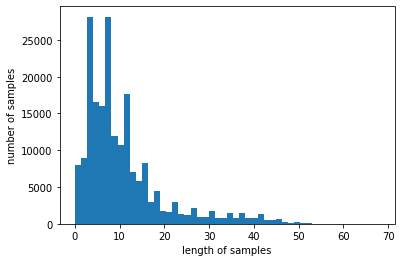

In [ ]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이: ' , max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이: ' , sum(map(len, tokenized_data))/len(tokenized_data))

plt.hist([len(f) for f in tokenized_data] , bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
model = Word2Vec(sentences = tokenized_data,
                 size = 100,
                 window = 5,
                 min_count = 5,
                 workers = 4,
                 sg = 0)

In [ ]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

In [ ]:
print(model.wv.most_similar('최민식'))

[('한석규', 0.8634374737739563), ('윤제문', 0.8569276928901672), ('오광록', 0.849298357963562), ('김명민', 0.8489696979522705), ('채민서', 0.8477553725242615), ('김수현', 0.8438879251480103), ('중견', 0.8376559019088745), ('엄태웅', 0.826805055141449), ('서영희', 0.8253761529922485), ('이정재', 0.8246971368789673)]


In [ ]:
print(model.wv.most_similar('히어로'))

[('느와르', 0.8801765441894531), ('블록버스터', 0.8761626482009888), ('무비', 0.8681313395500183), ('무협', 0.8595873713493347), ('슬래셔', 0.8575347661972046), ('홍콩', 0.839981198310852), ('호러', 0.8249687552452087), ('헐리우드', 0.8221017122268677), ('멜로', 0.8152731657028198), ('물', 0.8145992755889893)]


In [ ]:
model.wv.save_word2vec_format('kor_movie_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format('kor_movie_w2v') # 모델 로드

# 위키피디아
- 한국어 덤프파일 다운로드

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -l '/content/drive/My Drive/Colab Notebooks/Natural_Language_Processing/data'

total 6192639
-rw------- 1 root root 3644258522 Mar 27 14:06 GoogleNews-vectors-negative300.bin
-rw------- 1 root root 1647046227 Mar 27 14:06 GoogleNews-vectors-negative300.bin.gz
-rw------- 1 root root  745420346 Mar 27 10:34 kowiki-latest-pages-articles.xml.bz2
-rw------- 1 root root   80596565 Mar 27 14:10 ko.zip
-rw------- 1 root root   16035163 Mar 27 02:02 ted_en-20160408.zip
-rw------- 1 root root  207903212 Nov 18 12:30 wiki_data.txt


In [ ]:
!python -m wikiextractor.WikiExtractor /content/drive/My\ Drive/Colab\ Notebooks/Natural_Language_Processing/data/kowiki-latest-pages-articles.xml.bz2

INFO: Preprocessing '/content/drive/My Drive/Colab Notebooks/Natural_Language_Processing/data/kowiki-latest-pages-articles.xml.bz2' to collect template definitions: this may take some time.
INFO: Preprocessed 100000 pages
INFO: Preprocessed 200000 pages
INFO: Preprocessed 300000 pages
INFO: Preprocessed 400000 pages
INFO: Preprocessed 500000 pages
INFO: Preprocessed 600000 pages
INFO: Preprocessed 700000 pages
INFO: Preprocessed 800000 pages
INFO: Preprocessed 900000 pages
INFO: Preprocessed 1000000 pages
INFO: Preprocessed 1100000 pages
INFO: Preprocessed 1200000 pages
INFO: Preprocessed 1300000 pages
INFO: Preprocessed 1400000 pages
INFO: Preprocessed 1500000 pages
INFO: Loaded 53998 templates in 210.9s
INFO: Starting page extraction from /content/drive/My Drive/Colab Notebooks/Natural_Language_Processing/data/kowiki-latest-pages-articles.xml.bz2.
INFO: Using 1 extract processes.
INFO: Extracted 100000 articles (978.4 art/s)
INFO: Extracted 200000 articles (1360.8 art/s)
INFO: Extrac

### 1) 훈련데이터 전처리하기

In [ ]:
f = open('/content/drive/My Drive/Colab Notebooks/Natural_Language_Processing/data/wiki_data.txt',
         encoding = 'utf8')

- 5개 줄만 출력

In [ ]:
i = 0

while True :
  line = f.readline()
  if line != '\n' :
    i += 1
    print('%d번째 줄: ' %i + line)
  if i == 5 :
    break
f.close()

1번째 줄: <doc id="5" url="https://ko.wikipedia.org/wiki?curid=5" title="지미 카터">

2번째 줄: 지미 카터

3번째 줄: 제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39번째 대통령 (1977년 ~ 1981년)이다.

4번째 줄: 지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.

5번째 줄: 1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.



### 2) Word2Vec을 위한 학습데이터 생성

In [ ]:
%%time

okt = Okt()

fread = open('/content/drive/My Drive/Colab Notebooks/Natural_Language_Processing/data/wiki_data.txt',
             encoding = 'utf8')

n = 0
result = []

while True :
  line = fread.readline()   # 한줄씩 읽음
  if not line : break       # 모두 읽으면 while문 종료
  n += 1

  if n % 5000 == 0 :        # 5000의 배수로 실행될 때마다 몇번째 while문 실행인지 출력
    print('%d번째 While문' %n)

  tokenlist = okt.pos(line, stem = True, norm = True) # 단어 토큰화

  temp = []

  for word in tokenlist :
    if word[1] in ['Noun'] :  # 명사일 때만 해당 단어를 저장함
      temp.append((word[0]))

  if temp : # 읽은 데이터에 명사가 존재할 경우에만
    result.append(temp)

fread.close()

5000번째 While문
10000번째 While문
15000번째 While문
20000번째 While문
25000번째 While문
30000번째 While문
35000번째 While문
40000번째 While문
45000번째 While문
50000번째 While문
55000번째 While문
60000번째 While문
65000번째 While문
70000번째 While문
75000번째 While문
80000번째 While문
85000번째 While문
90000번째 While문
95000번째 While문
100000번째 While문
105000번째 While문
110000번째 While문
115000번째 While문
120000번째 While문
125000번째 While문
130000번째 While문
135000번째 While문
140000번째 While문
145000번째 While문
150000번째 While문
155000번째 While문
160000번째 While문
165000번째 While문
170000번째 While문
175000번째 While문
180000번째 While문
185000번째 While문
190000번째 While문
195000번째 While문
200000번째 While문
205000번째 While문
210000번째 While문
215000번째 While문
220000번째 While문
225000번째 While문
230000번째 While문
235000번째 While문
240000번째 While문
245000번째 While문
250000번째 While문
255000번째 While문
260000번째 While문
265000번째 While문
270000번째 While문
275000번째 While문
280000번째 While문
285000번째 While문
290000번째 While문
295000번째 While문
300000번째 While문
305000번째 While문
310000번째 While문
315000번째 While문
320000번째 Whi

In [2]:
print('총 샘플의 개수: {}' .format(len(result)))

NameError: ignored

In [ ]:
model = Word2Vec(result,
                 size = 100,
                 window = 5,
                 min_count = 5,
                 workers = 4,
                 sg = 0)

In [ ]:
model.wv.save_word2vec_format('003_word2vec_kor_wiki') # 모델 저장


In [ ]:
from google.colab import files
files.download('003_word2vec_kor_wiki')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 모델 로드
loaded_model = KeyedVectors.load_word2vec_format('003_word2vec_kor_wiki')